In [1]:
import numpy as np

In [2]:
# Build tree ... this is going to be tricky
def backtrace(frame, RMSD_frame, start_frame, print_trace=True):
    traj_length = 0
    trace = []
    trace.append(RMSD_frame[frame])
    r, s, f, rmsd = RMSD_frame[frame]
    fr, fs, ff, frmsd = RMSD_frame[frame]
    #print(f'Frame {frame:6d} is round {int(r):3d}, simulation {int(s):3d} and frame {int(f):3d}, rmsd {rmsd:6.3f} A')
    while r > 1:
        last_frame = start_frame[int(r)][int(s)]
        trace.append(RMSD_frame[last_frame])
        r, s, f, rmsd = RMSD_frame[last_frame]
    #    print(f'  which is from round {int(r):3d}, simulation {int(s):3d} and frame {int(f):3d}, rmsd {rmsd:6.3f} A')
    if print_trace:
        print(f'To arrive at frame {frame:6d} (round {int(fr):3d}, simulation {int(fs):3d} and frame {int(ff):3d}, rmsd {frmsd:6.3f} A):')
    for t in trace[::-1]: 
        r, s, f, rmsd = t
        traj_length += int(f)
        if print_trace:
            print(f'  From round {int(r):3d}, simulation {int(s):3d} and frame 0 to {int(f):3d} (rmsd {rmsd:6.3f} A)')
    if print_trace:
        print(f'Total traj length = {traj_length / 100} ns')
    return trace

In [3]:
def output_traj(frame, RMSD_frame, start_frame, psf=None, fname='traj.dcd'):
    try:
        import mdtraj
    except:
        print("mdtraj is not installed")
        return None
    if psf is None:
        print("Supply psf and try again")
        return None
    trace = backtrace(frame, RMSD_frame, start_frame, print_trace=False)[::-1]
    for idx, t in enumerate(trace):
        r, s, f, rmsd = t
        print(f'  From round {int(r):3d}, simulation {int(s):3d} and frame 0 to {int(f):3d} (rmsd {rmsd:6.3f} A)')
        if idx == 0:
            #traj = mdtraj.load(f'../Simulations/{int(r)}/{int(s)}/BBA_init.pdb', top=psf)
            traj = mdtraj.load(f'../Simulations/{int(r)}/{int(s)}/BBA_sample.dcd', top=psf)[:int(f)+1]
        else:
            #traj += mdtraj.load(f'../Simulations/{int(r)}/{int(s)}/BBA_init.pdb', top=psf)
            traj += mdtraj.load(f'../Simulations/{int(r)}/{int(s)}/BBA_sample.dcd', top=psf)[:int(f)+1]
    traj.save(fname)

In [4]:
# Get starting frames every round
start_frame = {}
for log in ['test6.log','test7.log','test8.log']:
    print(log)
    with open(log,'r') as f:
        cont = f.readlines()
    for idx, line in enumerate(cont):
        if "We are in round" in line:
            current_round = int(line.split()[-1].strip('!'))
        if "DBSCAN" in line:
            for idy in range(idx, idx+10):
                if cont[idy].startswith('['):
                    #print(cont[idy])
                    start_frame[current_round+1] = [int(x.strip(']')) for x in cont[idy].strip('[').split()]
                    break
start_frame[0] = [0]*6
start_frame[1] = [0]*6
RMSD_frame = np.load('../Simulations/data/RMSD_rounds_0_to_299.npy')
#print(RMSD_frame.shape)
#print(start_frame)

test6.log
test7.log
test8.log


In [5]:
def draw_progress(RMSD_frame, start_frame, frames=None):
    import matplotlib.pyplot as plt
    RMSD_plot = np.zeros((len(RMSD_frame), 2))
    RMSD_plot[:, 0] = RMSD_frame[:, 0] + (1+RMSD_frame[:, 2])/(1+np.max(RMSD_frame[:, 2]))
    RMSD_plot[:, 1] = RMSD_frame[:, -1]
    start_plot = []
    # start_frame[0] = start_frame[1]
    for key in start_frame:
        for val in start_frame[key]:
            start_plot.append([key, RMSD_frame[val, -1]])
    start_plot = np.array(start_plot)
    RMSD_plot = np.vstack([RMSD_plot, start_plot])
    
    plt.figure(dpi=300, figsize=(5, 45))
    plt.hlines(range(0, int(np.max(RMSD_frame[:,0])) + 1, 1), 
               np.min(RMSD_frame[:, -1]), np.max(RMSD_frame[:, -1]), 'k', linewidth=0.3, alpha=0.5)
    plt.scatter(RMSD_plot[:, 1], RMSD_plot[:, 0], s=0.3, c='k', marker=',', alpha=0.1)
    plt.scatter(start_plot[:, 1], start_plot[:, 0], s=0.8, c='tab:red')
    plt.ylim([0, np.max(RMSD_plot[:,0])])
    plt.grid(alpha=0.3)
    plt.gca().invert_yaxis()
    

    if frames is None:
        return None
    
    if type(frames) is int:
        frames = [frames]

    for frame in frames:
        print(f'building trace for frame {frame}')
        trace = backtrace(frame, RMSD_frame, start_frame, print_trace=False)[::-1]
        trace_frame = np.empty((0, RMSD_frame.shape[-1]))
        for idx, t in enumerate(trace):
            r, s, f, rmsd = t
            # print(r, s, f, rmsd)
            # print(RMSD_frame[(np.isclose(RMSD_frame[:, 0], r)) * (np.isclose(RMSD_frame[:, 1], s)) * (RMSD_frame[:, 2] <= f)])
            RMSD_start = [r, s, -1, RMSD_frame[start_frame[int(r)][int(s)], -1]]
            trace_frame = np.vstack([trace_frame, 
                                     RMSD_start,
                                     RMSD_frame[(np.isclose(RMSD_frame[:, 0], r)) * (np.isclose(RMSD_frame[:, 1], s)) * (RMSD_frame[:, 2] <= f)]])
        # print(trace_frame)
        trace_plot = np.zeros((len(trace_frame), 2))
        trace_plot[:, 0] = trace_frame[:, 0] + (1+trace_frame[:, 2])/(1+np.max(RMSD_frame[:, 2]))
        trace_plot[:, 1] = trace_frame[:, -1]
        plt.plot(trace_plot[:, 1], trace_plot[:, 0], '-.', linewidth=0.5, markersize=0.5)


building trace for frame 261401
building trace for frame 314837
building trace for frame 261403
building trace for frame 314603
building trace for frame 278200
building trace for frame 293602
building trace for frame 314830
building trace for frame 278605
building trace for frame 344413
building trace for frame 315256


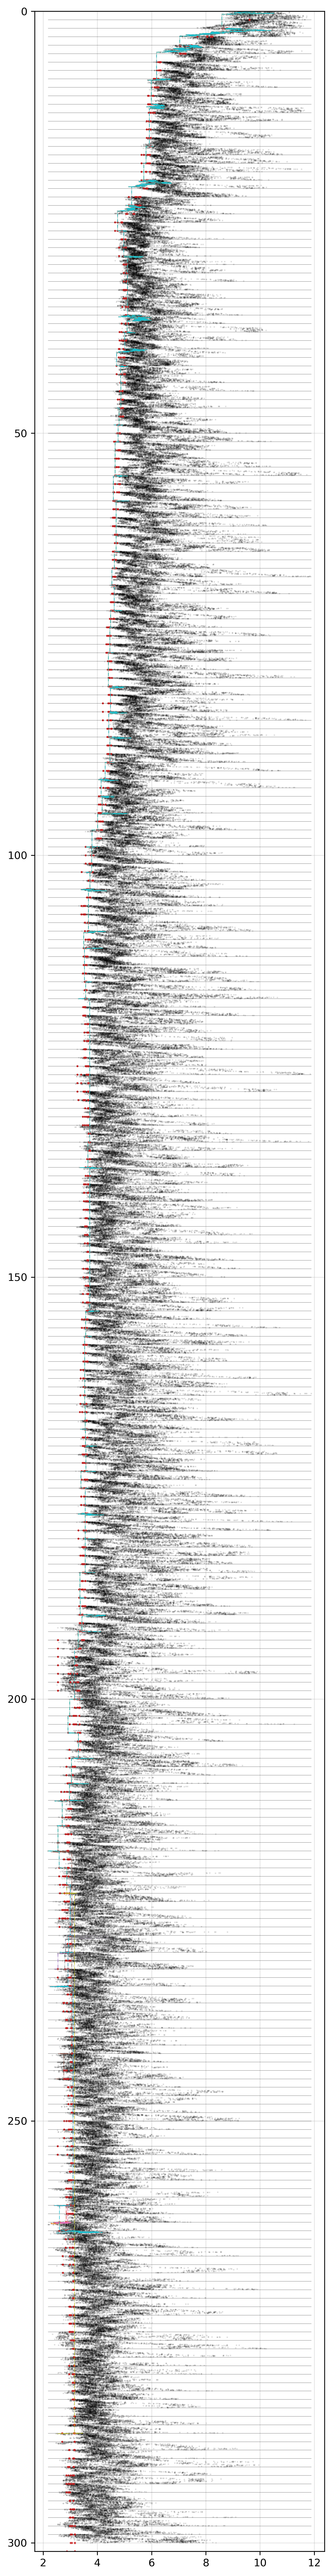

In [6]:
draw_progress(RMSD_frame, start_frame, 
              #rames=np.arange(len(RMSD_frame))[RMSD_frame[:,-1] < 2.5][:1],
              frames=np.argsort(RMSD_frame[:,-1])[:100:10])

In [84]:
for x in np.argsort(RMSD_frame[:, -1])[:1]:
    #backtrace(x, RMSD_frame, start_frame)
    output_traj(x, RMSD_frame, start_frame, psf='../Structures/1FME_wb_Cl.psf')
    print()


print(f'There are {np.sum(RMSD_frame[:, -1] < 2.5)} frames < 2.5 A RMSD to target')

  From round   0, simulation   3 and frame 0 to  70 (rmsd  8.594 A)
  From round   2, simulation   0 and frame 0 to 190 (rmsd  7.041 A)
  From round   4, simulation   2 and frame 0 to 169 (rmsd  6.186 A)
  From round   8, simulation   2 and frame 0 to  34 (rmsd  5.991 A)
  From round  11, simulation   4 and frame 0 to 111 (rmsd  5.920 A)
  From round  16, simulation   2 and frame 0 to   2 (rmsd  5.796 A)
  From round  18, simulation   2 and frame 0 to   0 (rmsd  5.713 A)
  From round  20, simulation   1 and frame 0 to 161 (rmsd  5.267 A)
  From round  23, simulation   0 and frame 0 to 135 (rmsd  4.744 A)
  From round  26, simulation   0 and frame 0 to  14 (rmsd  4.973 A)
  From round  29, simulation   2 and frame 0 to  37 (rmsd  5.112 A)
  From round  36, simulation   0 and frame 0 to 145 (rmsd  5.099 A)
  From round  38, simulation   5 and frame 0 to  22 (rmsd  5.009 A)
  From round  40, simulation   4 and frame 0 to  80 (rmsd  4.706 A)
  From round  42, simulation   0 and frame 0 to 